# LDA Topic Modeling

## Table of Contents

- Data Loading and Exploration
- Text Preprocessing
- Corpus Preparation and LDA Training
- Topic Analysis and Evaluation

In [37]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# NLTK for Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Progress Bar
from tqdm import tqdm

# Gensim for LDA Topic Modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# PyLDAvis for Topic Visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading and Exploration

In [2]:
beaverton_url = 'https://drive.google.com/uc?export=download&id=173t6vMYcbSED81IOmg0MbhHsrSFSiF21'
billnye_url = 'https://drive.google.com/uc?export=download&id=1w1Xm-TQfcPfGICM_8_LQiWSqzf8WUk8N'
georgetakei_url = 'https://drive.google.com/uc?export=download&id=1_Ck9S2aW9cBQQrqoTiNLRmvRu4WvPn8y'
cookiemonster_url = 'https://drive.google.com/uc?export=download&id=10Av-HVklZA4Su3TcvSpxU6nS8At9mJ05'
neiltyson_url = 'https://drive.google.com/uc?export=download&id=1GSKxxldXe--HE4gSYAEn2ip2vS4bXKMM'
stephenking_url = 'https://drive.google.com/uc?export=download&id=1Oq2pUCv0d7x4tDKX1E-3hgdSAuXcZtVU'
twentytwo_minutes_url = 'https://drive.google.com/uc?export=download&id=1B2zwAJYdw_9skXAFbn7QIs6uyIikje5W'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
beaverton = pd.read_excel(beaverton_url, engine='openpyxl')
beaverton.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03


In [4]:
billnye = pd.read_excel(billnye_url, engine='openpyxl')
billnye.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [5]:
georgetakei = pd.read_excel(georgetakei_url, engine='openpyxl')
georgetakei.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,He is still sorely missed. 💕 What is your favo...,georgetakei,2022-03-12
1,2,It’s terrifying but true. The GOP has become t...,georgetakei,2022-03-12
2,3,This is not normal.,georgetakei,2022-03-12
3,4,"Very well put, indeed.",georgetakei,2022-03-12
4,5,"With the former guy, mockery is the best polic...",georgetakei,2022-03-12


In [6]:
cookiemonster = pd.read_excel(cookiemonster_url, engine='openpyxl')
cookiemonster.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Today, me so thankful for chefs like me friend...",MeCookieMonster,2022-03-08
1,2,You can’t spell cookie without “oo.” Speaking ...,MeCookieMonster,2022-02-25
2,3,Me so grateful @SesameErnie\n. Me think sharin...,MeCookieMonster,2022-02-17
3,4,What do me love? Friends. Family. Cookies. Ple...,MeCookieMonster,2022-02-14
4,5,"Dipping cookies in milk? Me get it, but who ha...",MeCookieMonster,2022-01-28


In [7]:
neiltyson = pd.read_excel(billnye_url, engine='openpyxl')
neiltyson.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [8]:
stephenking = pd.read_excel(stephenking_url, engine='openpyxl')
stephenking.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,What kind of dinosaur writes romance novels? A...,StephenKing,2022-03-05
1,2,"Molly, aka the Thing of Evil, fools my friend ...",StephenKing,2022-02-25
2,3,Two questions (and a codicil) about MANIFEST: ...,StephenKing,2022-02-25
3,4,What most of us learned as kids on the playgro...,StephenKing,2022-02-23
4,5,"I need baseball! Come on you guys, stop being ...",StephenKing,2022-02-16


In [9]:
twentytwo_minutes = pd.read_excel(twentytwo_minutes_url, engine='openpyxl')
twentytwo_minutes.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"And in lighter news this week: Nope, sorry. We...",22Minutes,2022-03-03 00:00:00
1,2,Dee Snider of Twisted Sister says he approves ...,22Minutes,2022-03-03 00:00:00
2,3,Tim Hortons will be releasing their own line o...,22Minutes,2022-03-03 00:00:00
3,4,A new survey shows that 1 in 8 people suffer f...,22Minutes,2022-03-02 00:00:00
4,5,The Bank of Canada has raised its interest rat...,22Minutes,2022-03-02 00:00:00


In [10]:
beaverton['account'] = 'The Beaverton'
billnye['account'] = 'Bill Nye'
georgetakei['account'] = 'George Takei'
cookiemonster['account'] = 'Cookie Monster'
neiltyson['account'] = 'Neil deGrasse Tyson'
stephenking['account'] = 'Stephen King'
twentytwo_minutes['account'] = 'This Hour Has 22 Minutes'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
data = pd.concat([beaverton, billnye, georgetakei, cookiemonster, neiltyson, stephenking, twentytwo_minutes], ignore_index=True)
data.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05 00:00:00,The Beaverton
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04 00:00:00,The Beaverton
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04 00:00:00,The Beaverton
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04 00:00:00,The Beaverton
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03 00:00:00,The Beaverton


In [12]:
data.tail()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
1071,196,A student at U of T is launching a city-wide s...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1072,197,New poll shows nearly half of Canadians don’t ...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1073,198,Apple has introduced the iPhone 13! Huge! Mass...,22Minutes,2021-09-16 00:00:00,This Hour Has 22 Minutes
1074,199,The Price Is Right is celebrating its 50th yea...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes
1075,200,Some restaurants are reporting a shortage of c...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes


In [13]:
data.info()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet-id              1076 non-null   int64 
 1   tweet-text            1076 non-null   object
 2   tweet-author          1076 non-null   object
 3   tweet-timestamp-date  1076 non-null   object
 4   account               1076 non-null   object
dtypes: int64(1), object(4)
memory usage: 42.2+ KB


## Text Preprocessing

In [14]:
# to initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def preprocess_text(text):
    """
    Preprocesses text by expanding contractions, removing punctuation, tokenizing,
    lowercasing, removing stopwords and numbers, lemmatizing,
    and filtering short words (≤2 characters). Returns a list of cleaned tokens.
    """

    text = re.sub(r"n't", " not", text) # "can't" → "can not"
    text = re.sub(r"'m", " am", text) # "I'm" → "I am"
    text = re.sub(r"'re", " are", text) # "You're" → "You are"
    text = re.sub(r"'ll", " will", text) # "I'll" → "I will"
    text = re.sub(r"'ve", " have", text) # "I've" → "I have"
    text = re.sub(r"'s", "", text) # "child's" → "child"

    text = re.sub(r"[^\w\s]", "", text) # removes all punctuation after expanding contractions

    tokens = word_tokenize(text) # tokenization

    tokens = [token.lower() for token in tokens] # lowercasing

    tokens = [token for token in tokens if token not in stop_words] # removes stop words

    tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatization

    # to remove short words (<=2 characters, except "I" and "am")
    # "I" is a valid pronoun and often important for sentence meaning.
    # "am" is a verb and critical for sentence structure (e.g., "I am happy" → "happy" loses meaning).
    tokens = [token for token in tokens if len(token) > 2 or token in {"i", "am"}]

    tokens = [token for token in tokens if not token.isdigit()] # removes numbers

    return tokens

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
tqdm.pandas() # tqdm.pandas() integrates the tqdm progress bar with pandas, allowing you to track progress when using .apply() on DataFrames or Series.

data['processed_tweet_text'] = data['tweet-text'].progress_apply(preprocess_text)
data[['tweet-text', 'processed_tweet_text']].head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1076/1076 [00:08<00:00, 125.44it/s]


,tweet-text,processed_tweet_text
0,Heartwarming: This man reconnected with his mo...,"[heartwarming, man, reconnected, mom, could, a..."
1,OP-ED: Big Pharma put all of the chips in the ...,"[oped, big, pharma, put, chip, vaccine, get, ps5]"
2,Make every day a 'talking to Americans about t...,"[make, every, day, talking, american, healthca..."
3,Single drop of sweat falls down local dad’s fa...,"[single, drop, sweat, fall, local, dad, face, ..."
4,100% of Canadians pretty sure they’ve had COVI...,"[canadian, pretty, sure, theyve, covid, already]"


In [17]:
for text in data['processed_tweet_text'].head(25):
    print(text)

['heartwarming', 'man', 'reconnected', 'mom', 'could', 'ask', 'tax']
['oped', 'big', 'pharma', 'put', 'chip', 'vaccine', 'get', 'ps5']
['make', 'every', 'day', 'talking', 'american', 'healthcare', 'system', 'level', 'smug', 'day', 'shirt']
['single', 'drop', 'sweat', 'fall', 'local', 'dad', 'face', 'tell', 'daycare', 'worker', 'child', 'doesnt', 'runny', 'nose']
['canadian', 'pretty', 'sure', 'theyve', 'covid', 'already']
['local', 'fiancé', 'insists', 'buying', 'wedding', 'ring', 'bulk', 'totally', 'normal']
['congressional', 'bouncer', 'apologize', 'admitting', 'rowdy', 'bachelorette', 'party', 'state', 'union', 'stateoftheunion']
['immersive', 'art', 'experience', 'really', 'two', 'sens']
['political', 'cartoonist', 'mistaken', 'impression', 'political', 'cartoonist', 'never', 'important']
['climate', 'change', 'considering', 'makeover', 'stand', 'amongst', 'shiny', 'new', 'calamity']
['scientist', 'invents', 'time', 'travel', 'mock', 'people', 'thought', 'thing', 'bad']
['quiz', 'r

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Corpus Preparation and LDA Training

Topic modelling involves counting words and grouping similar word patterns to describe topics within the data. If the model knows the word frequency, and which words often appear in the same document, it will discover patterns that can group different words together.


In [18]:
# Creates a dictionary where each unique word gets a unique integer ID.
# The dictionary stores how many times each word appears across all documents.
id2word = corpora.Dictionary(data['processed_tweet_text'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Converts each document (text, which is a list of words) into a sparse vector.
corpus = [id2word.doc2bow(text) for text in data['processed_tweet_text']]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('ask', 1),
  ('could', 1),
  ('heartwarming', 1),
  ('man', 1),
  ('mom', 1),
  ('reconnected', 1),
  ('tax', 1)]]

Now, let's build an **LDA topic model**.

### Why These Parameters?

- `num_topics=15`: Sets the number of topics. Too few can mix unrelated words, and too many can make topics less clear. **Testing different numbers helps find the best fit.**
- `passes=50`: Runs the model multiple times to refine topics. More passes help improve results, but too many won't add much value.
- `update_every=1`: Updates the model after each batch of documents, making training faster and more efficient, especially for large datasets.
- `chunksize=200`: Processes 200 documents at a time, helping the model find clearer topics while keeping training fast.
- `alpha='auto'`: Lets the model decide if a document should focus on one topic or mix multiple topics.
- `per_word_topics=False`: Speeds up training by skipping extra details about individual words, which are usually not needed.

In [21]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=15, # It will be adjusted based on coherence score testing.
    passes=50,
    update_every=1,
    chunksize=200,
    alpha='auto',
    per_word_topics=False
)

# The coherence score measures how well the words in a topic are related, helping us evaluate the quality of the LDA model.
# A higher coherence score means better topics, making the model more useful!
coherence_model = CoherenceModel(
    model=lda_model,
    texts=data['processed_tweet_text'],
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"LDA Model Trained on All Accounts (Coherence Score: {coherence_score:.4f})")
print("-" * 100)
for topic in lda_model.print_topics(num_words=10):
    print(topic)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Model Trained on All Accounts (Coherence Score: 0.5138)
----------------------------------------------------------------------------------------------------
Topic 1: 0.044*"dont" + 0.036*"national" + 0.030*"something" + 0.027*"pandemic" + 0.024*"home" + 0.022*"covid" + 0.019*"remember" + 0.019*"tweet" + 0.017*"money" + 0.016*"punctuation"
Topic 2: 0.105*"cookie" + 0.098*"cooky" + 0.032*"dis" + 0.029*"friend" + 0.029*"love" + 0.020*"monster" + 0.016*"apple" + 0.015*"truck" + 0.014*"chocolate" + 0.014*"mind"
Topic 3: 0.065*"thing" + 0.044*"two" + 0.031*"evil" + 0.031*"call" + 0.029*"molly" + 0.029*"know" + 0.027*"night" + 0.022*"aka" + 0.022*"another" + 0.017*"three"
Topic 4: 0.049*"see" + 0.034*"also" + 0.033*"taco" + 0.026*"big" + 0.021*"far" + 0.018*"made" + 0.018*"yet" + 0.016*"world" + 0.015*"average" + 0.015*"scientist"
Topic 5: 0.036*"lot" + 0.029*"cdnpoli" + 0.027*"half" + 0.025*"news" + 0.024*"woman" + 0.023*"election" + 0.021*"elxn44" + 0.020*"toronto" + 0.020*"would" + 0.0

## Topic Analysis and Evaluation

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


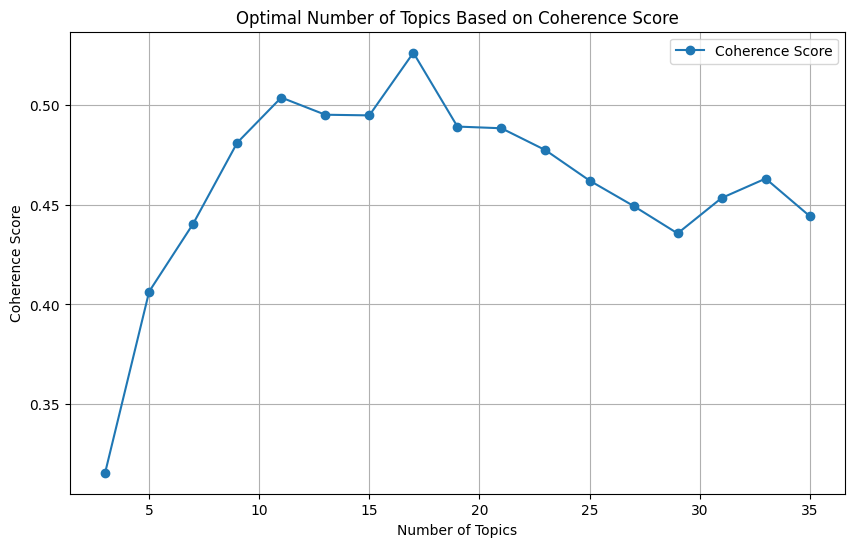

In [22]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    num_topics_list = range(start, limit + 1, step)

    for num_topics in num_topics_list:
        model = gensim.models.LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=50,
            update_every=1, chunksize=200, alpha='auto', per_word_topics=False)
        model_list.append(model)

        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values, num_topics_list

model_list, coherence_values, num_topics_list = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data['processed_tweet_text'],
    start=3,
    limit=35,
    step=2
)

plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_values, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Based on Coherence Score")
plt.legend(["Coherence Score"], loc='best')
plt.grid(True);

We will use the model with the highest coherence score:

In [33]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
best_num_topics = num_topics_list[best_result_index]

print(f"The optimal number of topics is {best_num_topics}, achieving the highest coherence score of {coherence_values[best_result_index]:.4f}.")
print("-" * 100)
for topic in optimal_model.print_topics(num_words=10):
    print(topic)

The optimal number of topics is 17, achieving the highest coherence score of 0.5264.
----------------------------------------------------------------------------------------------------
(0, '0.036*"kid" + 0.035*"want" + 0.026*"birthday" + 0.025*"pretty" + 0.019*"hope" + 0.018*"away" + 0.017*"book" + 0.015*"went" + 0.013*"planning" + 0.013*"small"')
(1, '0.034*"big" + 0.034*"hour" + 0.027*"stop" + 0.027*"made" + 0.025*"nasa" + 0.022*"life" + 0.018*"missed" + 0.018*"deal" + 0.017*"vaccine" + 0.015*"bad"')
(2, '0.054*"could" + 0.039*"due" + 0.034*"sure" + 0.023*"eating" + 0.020*"hard" + 0.020*"youre" + 0.018*"looking" + 0.017*"since" + 0.015*"keep" + 0.015*"true"')
(3, '0.084*"call" + 0.029*"pandemic" + 0.023*"order" + 0.016*"trying" + 0.016*"pizza" + 0.013*"billionaire" + 0.009*"accidentally" + 0.009*"killed" + 0.008*"education" + 0.006*"earth"')
(4, '0.053*"well" + 0.049*"need" + 0.048*"good" + 0.027*"car" + 0.027*"bill" + 0.025*"stay" + 0.023*"asteroid" + 0.021*"wonder" + 0.021*"asked"

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's see how the words are clustered using pyLDAVis.

In [24]:
p = gensimvis.prepare(optimal_model, corpus, id2word)
p

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.442383 -0.019469       1        1  30.617352
15     0.000159  0.287535       2        1   8.759740
5     -0.023776  0.060180       3        1   5.643918
1     -0.020761  0.063300       4        1   5.568807
14    -0.016519 -0.083388       5        1   5.562248
0      0.001099 -0.011035       6        1   5.326120
12    -0.022317  0.022514       7        1   4.914634
8     -0.037776 -0.017101       8        1   4.809378
2     -0.029717 -0.079568       9        1   4.548854
13    -0.022655 -0.051685      10        1   4.405943
7     -0.032540 -0.037971      11        1   4.131671
4     -0.036858 -0.036937      12        1   4.069906
10    -0.038396 -0.023230      13        1   2.980569
9     -0.045081 -0.006497      14        1   2.978848
6     -0.032241 -0.030451      15        1   2.642615
16    -0.038934 -0.022947      16        1   1.999095
3     -0.046070 -0.013250      17        1   1.040304, topic_info=            Term        Freq       Total Category  logprob  loglift
375         like   54.000000   54.000000  Default  30.0000  30.0000
16           day  186.000000  186.000000  Default  29.0000  29.0000
81           new  183.000000  183.000000  Default  28.0000  28.0000
148          say  161.000000  161.000000  Default  27.0000  27.0000
1077         got   50.000000   50.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3698  zuckerberg    0.025586    0.990252  Topic17  -8.5250   0.9098
2119       break    0.025599    0.990914  Topic17  -8.5245   0.9096
2657        said    0.025699    0.996946  Topic17  -8.5206   0.9074
2667    facebook    0.025586    0.991453  Topic17  -8.5250   0.9085
2669      outage    0.025586    0.990355  Topic17  -8.5250   0.9097

[640 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1215      7  0.886806           4th
829      14  0.874095          able
914       6  0.905438        access
473      17  0.456842  accidentally
136      15  0.811582           act
...     ...       ...           ...
1124     13  0.886633         young
381       5  0.118605         youre
381       8  0.177907         youre
381       9  0.652326         youre
621      15  0.750206          zoom

[682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 16, 6, 2, 15, 1, 13, 9, 3, 14, 8, 5, 11, 10, 7, 17, 4])

**Topic 1** is the most dominant, represented by the largest circle in the Intertopic Distance Map and contributing significantly to the marginal topic distribution. **Topic 2** also stands out, as it is positioned far from the rest, indicating a distinct and specialized theme. Meanwhile, the remaining topics (e.g., **3**, **5**, **6**, etc.) are smaller and more closely clustered, suggesting they capture specific or overlapping subthemes within the broader discussions.

**Topic 1** is the largest and focuses on **current events, trends, and global issues**. Words like "**day**," "**new**," "**say**," "**today**," "**year**," and "**world**" highlight discussions about daily updates and global concerns. Terms like "**change**" and "**climate**" suggest that environmental issues are a key part of this topic.

**Topic 2** is unique and focuses on **space exploration and global reflections**. Words like "**space**," "**exploration**," "**celebrate**," "**pandemic**," and "**national**" show themes of celebrating achievements in science and reflecting on global challenges. This topic also includes words like "**mind**" and "**answer**," suggesting deeper thinking or commemorations tied to recent events.

**Topic 3** centers around **scientific progress, space missions, and global problems**. Words like "**nasa**," "**spacex**," "**exploreplanets**," "**pandemic**," "**vaccine**," and "**earth**" highlight themes of exploring space and addressing challenges like health and climate. Terms like "**big**" and "**congratulation**" suggest celebrating milestones in science and technology.

**Topic 5** focuses on **Canada-specific issues, entertainment, and challenges**. Words like "**canada**," "**election**," "**movie**," and "**science**" reflect discussions about national topics and cultural interests. Terms like "**challenge**" and "**school**" point to solving problems and education, while words like "**netflix**" add an entertainment aspect.

Now, let's compare the **distribution of topics across user accounts** based on the **optimal LDA model**.

Processing Accounts: 100%|██████████| 7/7 [00:00<00:00, 21.36it/s]


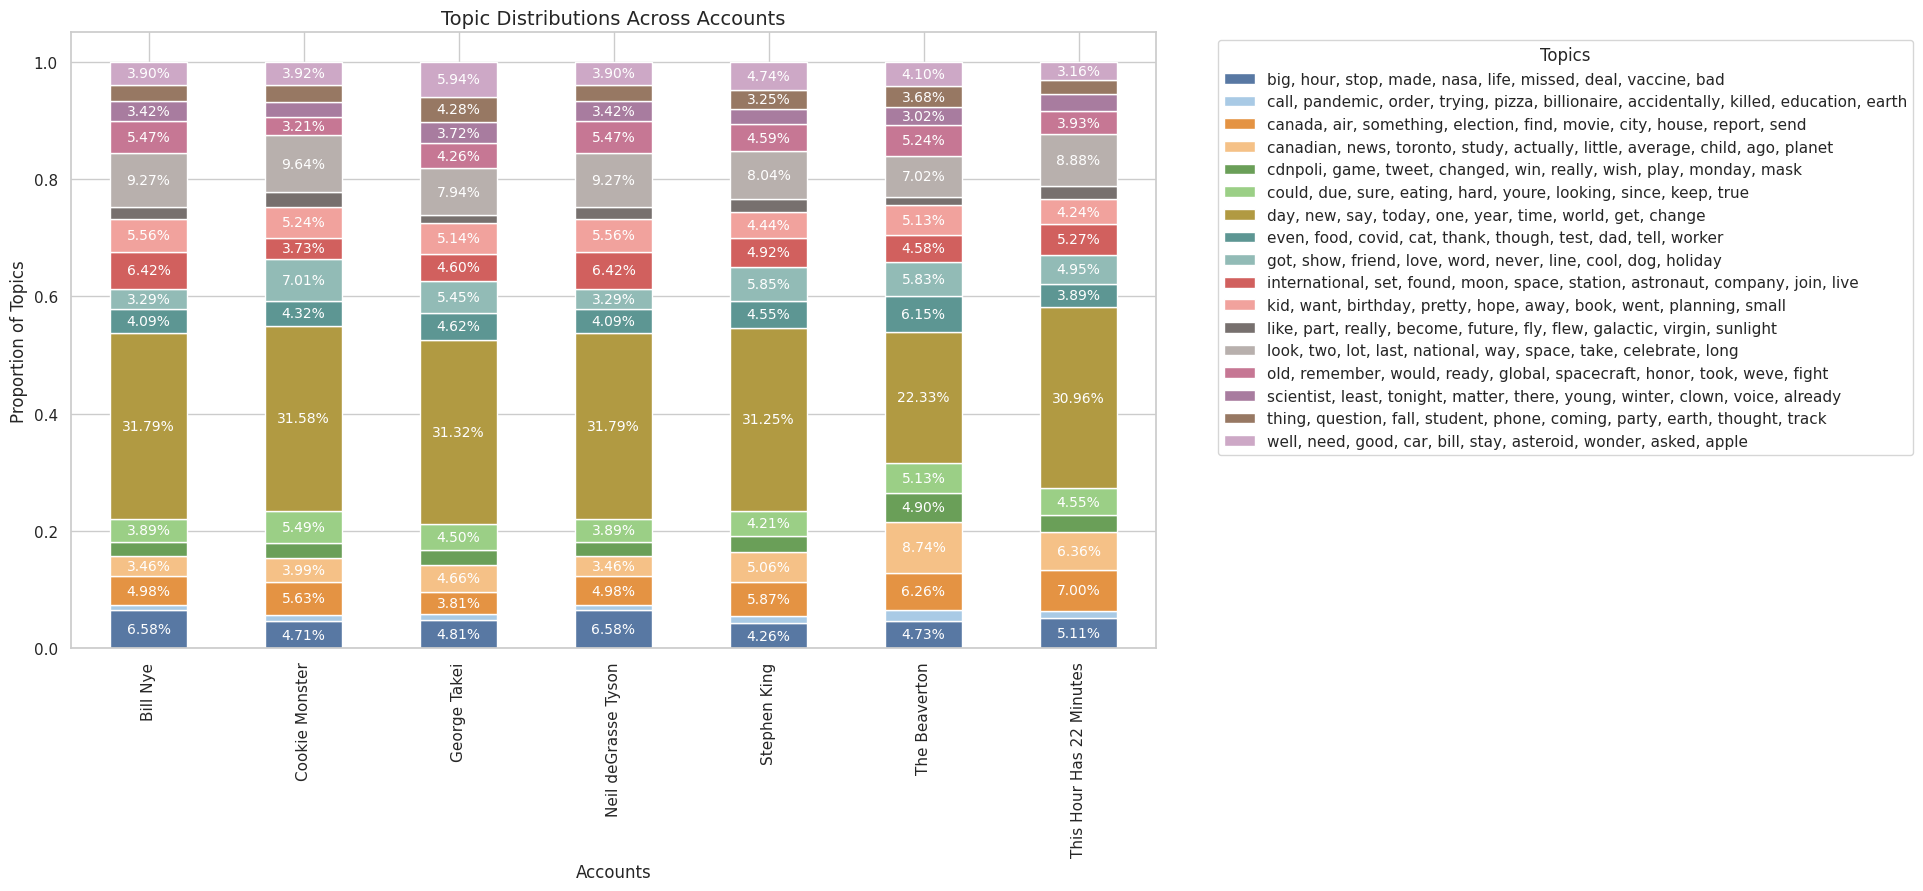

In [55]:
custom_palette = [
    "#5878a3", "#a9cae5", "#e49343", "#f5c187", "#6a9f58", "#9bcf86",
    "#b19a42", "#5d9693", "#92bbb6", "#d1605e", "#f1a29d", "#77706e",
    "#b8b0ad", "#c67794", "#a87c9f", "#977863", "#cda8c6"
]

account_topic_distribution = defaultdict(list) # dictionary to store topic distributions for each user

for account in tqdm(data['account'].unique(), desc="Processing Accounts"):
    account_data = data[data['account'] == account]

    account_corpus = [id2word.doc2bow(text) for text in account_data['processed_tweet_text']]

    topic_distributions = [optimal_model.get_document_topics(doc, minimum_probability=0.0) for doc in account_corpus]

    # to calculate average topic distribution for this account
    if topic_distributions:
        average_distribution = np.mean([[prob for _, prob in doc] for doc in topic_distributions], axis=0)

        account_topic_distribution[account] = average_distribution

# to convert the topic distributions into a DataFrame
topic_labels = [f"{', '.join([word for word, _ in optimal_model.show_topic(i, topn=10)])}" for i in range(best_num_topics)]
topic_distribution_df = pd.DataFrame(account_topic_distribution, index=topic_labels)

sorted_accounts = topic_distribution_df.T.sum(axis=1).sort_values(ascending=False).index
topic_distribution_df = topic_distribution_df[sorted_accounts]

df_melted = topic_distribution_df.T.reset_index().melt(id_vars="index", var_name="Topic", value_name="Proportion")
df_melted.rename(columns={"index": "Account"}, inplace=True)

df_pivot = df_melted.pivot(index="Account", columns="Topic", values="Proportion")

fig, ax = plt.subplots(figsize=(14, 8))
df_pivot.plot(kind="bar", stacked=True, color=custom_palette, ax=ax)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0.03: # shows labels only for values >3% to reduce clutter
            ax.text(bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2.,
                    f"{height:.2%}", ha='center', va='center', fontsize=10, color="white")

plt.title("Topic Distributions Across Accounts", fontsize=14)
plt.xlabel("Accounts", fontsize=12)
plt.ylabel("Proportion of Topics", fontsize=12)
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left');

A dominant theme, encompassing words like "**day**," "**new**," "**say**," and "**today**," is prevalent across all accounts, accounting for over **30%** of the content in most cases. This reflects a shared emphasis on **daily updates and general commentary**. Alongside this dominant theme, notable variations emerge among the accounts. For instance, **Bill Nye**, **Neil deGrasse Tyson**, and **Cookie Monster** exhibit a significant focus on exploration and global topics, as seen in terms such as "look," "two," and "national." In contrast, The Beaverton includes a diverse range of themes, prominently featuring political commentary and event-specific discussions, indicated by words like "could," "tweet," and "game."

Stephen King's account, while also emphasizing daily updates, includes a distinctive focus on Canadian news and studies, as reflected in words like "Canadian," "news," and "Toronto." Smaller themes related to space exploration, pandemics, and social observations appear less frequently but are consistently present across multiple accounts. Examples include terms like "international," "moon," "call," and "pandemic." Cookie Monster's account stands out with its unique emphasis on practical, relatable topics, highlighted by terms such as "well," "need," and "good." Meanwhile, The Beaverton's content spans a broad thematic spectrum, including a strong representation of political satire.

This visualization offers a clear and insightful comparison of the thematic priorities across the accounts, illustrating both commonalities and unique focuses in their content.